# Logistic Regression

## Introduction
In this notebook, we will work with a dataset that I retrieved from [Kaggle](https://www.kaggle.com/mustafaali96/weight-height). The dataset contains weights (in pounds) and heights (in inches) of people seperated by gender. We are going to try to classify the gender from these features.

### What is the Logistic Regression ?
Logistic Regression is commonly used for binary Classification problems in Machine Learning. It can also be used Multiclass Classification with One vs Rest approach. We are going to focus on only a binary classification problem here. The model's name comes from the logistic function (also known as sigmoid).
<br>
<img src="sigmoid-logistic.png" width="240px" height="240px" align="left"/>
<br><br><br><br><br><br><br>
We can easily visualize the sigmoid function with seaborn like following.


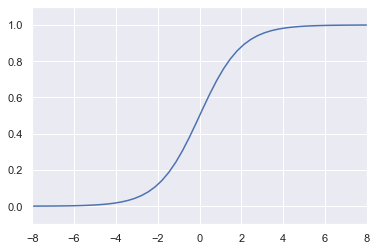

In [1]:
# Import Fundamentals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the logistic function
sns.set()
plt.xlim([-8, 8])
plt.ylim([-0.1, 1.1])
x= np.linspace(-8,8)
y = 1/(1+np.exp(-x))
sns.lineplot(x,y)

## 1. Importing data
Let's start with importing the libraries/packages that we are going to use.

In [2]:
# for Standardization of the features
from sklearn.preprocessing import StandardScaler

# for label encoding
from sklearn.preprocessing import LabelEncoder

# for building the model
from sklearn.linear_model import LogisticRegression

# for splitting the data into train and test sets
from sklearn.model_selection import train_test_split

# for Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# for testing the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# I will keep the resulting plots
%matplotlib inline

# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True

Now we can import our data into a DataFrame

In [3]:
data = pd.read_csv('../datasets/weight-height.csv')

## 2. Explore the data
It is always good practice to do exploratory data analysis before building any models

In [4]:
# Convert Gender's datatype to category
data['Gender'] = data['Gender'].astype('category')

# Convert height inches to centimeters
data["Height(cm)"] = data["Height"]*2.54

# Convert weight pounds to kilograms
data["Weight(kg)"] = data["Weight"]*0.45359237

# Display first five rows of the DataFrame
display(data.head())

# Get fundamental information about the DataFrame
display(data.info())

# We can also look at summary statistics
display(data.describe())

# Count the Genders
display(data.Gender.value_counts())

,Gender,Height,Weight,Height(cm),Weight(kg)
0,Male,73.847017,241.893563,187.571423,109.721075
1,Male,68.781904,162.310473,174.706036,73.622792
2,Male,74.110105,212.740856,188.239668,96.497629
3,Male,71.730978,220.042470,182.196685,99.809586
4,Male,69.881796,206.349801,177.499761,93.598695


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Gender      10000 non-null  category
 1   Height      10000 non-null  float64 
 2   Weight      10000 non-null  float64 
 3   Height(cm)  10000 non-null  float64 
 4   Weight(kg)  10000 non-null  float64 
dtypes: category(1), float64(4)
memory usage: 322.5 KB


None

,Height,Weight,Height(cm),Weight(kg)
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,66.367560,161.440357,168.573602,73.228114
std,3.847528,32.108439,9.772721,14.564143
min,54.263133,64.700127,137.828359,29.347484
25%,63.505620,135.818051,161.304276,61.606032
50%,66.318070,161.212928,168.447898,73.124954
75%,69.174262,187.169525,175.702625,84.898668
max,78.998742,269.989699,200.656806,122.465267


Male      5000
Female    5000
Name: Gender, dtype: int64

As we can see above, our dataset is balanced (by Gender). Now, we are going to Standardize our numerical features and encode the labels to train the machine learning model. We'll also visualize our dataset.

,Gender,Height,Weight,Height(cm),Weight(kg),Gender_encoded,Height_scaled,Weight_scaled
0,Male,73.847017,241.893563,187.571423,109.721075,1,1.944061,2.505797
1,Male,68.781904,162.310473,174.706036,73.622792,1,0.627537,0.027101
2,Male,74.110105,212.740856,188.239668,96.497629,1,2.012443,1.597806
3,Male,71.730978,220.042470,182.196685,99.809586,1,1.394060,1.825222
4,Male,69.881796,206.349801,177.499761,93.598695,1,0.913421,1.398750


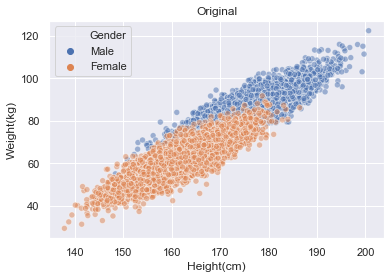

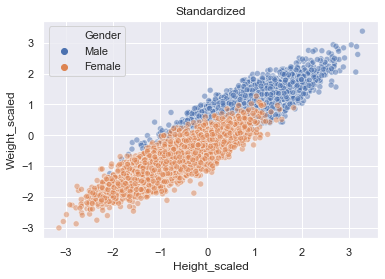

In [5]:
# Encode the labels
le = LabelEncoder()
data.loc[:,'Gender_encoded'] = le.fit_transform(data.loc[:,'Gender'])

# Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['Height(cm)','Weight(kg)']])
data['Height_scaled'] = data_scaled[:,0] 
data['Weight_scaled'] = data_scaled[:,1]
# Print the first five rows of the DataFrame again
display(data.head())

# Extract the features
X = data.loc[:,['Height_scaled','Weight_scaled']]
y = data.loc[:,'Gender_encoded']

# Visualize the data
sns.scatterplot(x='Height(cm)',y='Weight(kg)',hue='Gender',alpha=0.5,data=data)
plt.title("Original")
plt.show()

# Visualize the data
sns.scatterplot(x='Height_scaled',y='Weight_scaled',hue='Gender',alpha=0.5,data=data)
plt.title("Standardized")
plt.show()

## 3. Build the model

First of all, we have to split our data into the training and test sets. After that, we are going to fit our LogisticRegression model. We are going to use GridSearchCV for hyperparameter tuning.

In [6]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=34,test_size=0.3,stratify=y)

# Create a dictionary to be used GridSearchCV in hyperparameter tuning
parameters = {'penalty':['l1', 'l2'],'C':[1,0.1,0.01,0.001,0.0001,0.00001]}

# Initialize our LogisticRegression Classifier
lr = LogisticRegression()

# Initialize our GridSearchCV
clf = GridSearchCV(estimator=lr,param_grid=parameters,cv=10,n_jobs=-1)

# Fit the model
clf.fit(X_train, y_train)

# Print the best parameters and the best accuracy
print("Best parameters: ",clf.best_params_)
print("Best accuracy: ",clf.best_score_)

Best parameters:  {'C': 1, 'penalty': 'l2'}
Best accuracy:  0.9174285714285715


GridSearchCV revealed that C=1 and penalty=l2 (Ridge regression) are the best parameters among parameters that we searched. The best accuracy is also %91.7 . Let's visualize our decision boundary.

Coefficients: [-1.68597441  5.98455383]
Intercept: [0.03847291]


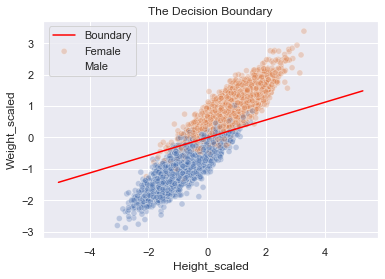

In [7]:
# Initialize a LogisticRegression Classifier with best parameters
lr_best = clf.best_estimator_
lr_best.fit(X_train, y_train)

# Print the coefficents and the intercept
coef = lr_best.coef_.ravel()
intercept = lr_best.intercept_
print("Coefficients:",coef)
print("Intercept:",intercept)

# Plot the decision boundary
sns.scatterplot(x=X_train["Height_scaled"],y=X_train["Weight_scaled"],hue=y_train,alpha=0.3)
x = np.array([min(X_train["Height_scaled"]) - 2, max(X_train["Height_scaled"]) + 2])
y = (-1/coef[1]) * (coef[0] * x + intercept)
sns.lineplot(x=x,y=y,color="red")
plt.legend(["Boundary","Female","Male"])
plt.title("The Decision Boundary")
plt.show()

## 4. Evaluate the model

Now, it's time to evaluate our model's performance in addition to accuracy metric. Since our data set is balanced, we do not actually need to calculate ROC AUC score but let's do that for practice.

Confusion Matrix

[[1379  121]
 [ 107 1393]]


Classification Report

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1500
           1       0.92      0.93      0.92      1500

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000


ROC AUC Score: 0.9239999999999999


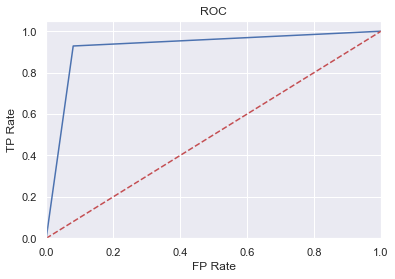

In [8]:
# Predict from our test set
y_pred = lr_best.predict(X_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)


# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:",auc_score)

# Get probabilities.
y_pred_proba = lr_best.predict(X_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Visualize the ROC curve.
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC')
plt.show()



That's the end of this notebook. I hope it is helpful for understanding Logistic Regression